In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geopandas.tools import sjoin
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import split, snap
import shapely.wkb
import networkx as nx
import folium
import matplotlib.pyplot as plt

<center><h3>
Using open data, build a network of road and postcode intersections and use it to calculate the shortest paths by distance from postcodes in a target radius to the location of interest, like hospital.
</h3></center>

**Known issues:**
- Smaller postcodes that don't have any roads passing directly through them are missing from the calculation. One solution would be to find the closest road to such a postcode from its centroid, but that strays into the multi-modal travel territory, i.e. walking and driving
- Scalability. The network needs to generated only once, but for large areas that might take a while as this approach is pure brute force, checking each road for intersection with every other road. 

#### Run this cell to download the postcode shapefiles and the highway data from OSM
This might take some time. File sizes are 67mb for the postcodes and 254mb for the highway data which is distributed together with other shapefiles for Scotland

In [2]:
%run get_data.py

** Finished! **
** Finished! **


#### Functions to format and clean data:

In [3]:
def point_rounding(geometry):
    """
    Shapely operations like intersection return coordinates to 15 digits or more
    this can lead to problems where nodes are ever so slightly outside the roads
    they are supposed to be on.
    """
    
    if geometry.geom_type == 'Point':
        return Point(round(geometry.x, 7), round(geometry.y, 7))
    raise TypeError('Geometry is not a Point')

In [4]:
def radius_geometry(lat, long, radius):
    """
    Latitude and Longitude must be supplied in EPSG 4326 (Google Maps, etc.)
    Returns a GeoDataFrame ready for clipping other GeoDataFrames (postcodes and roads)
    """

    p = Point(long, lat)

    point_df = gpd.GeoDataFrame([{'id':1, 'geometry':p}], crs={'init':'epsg:4326'})

    #reproject Google's lat/long (epsg:4326) to epsg:27700 (BNG) where coordinates are in meters
    point_df = point_df.to_crs({'init':'epsg:27700'})

    #draw a radius around the given coordinates and re-project back to 4326
    radius_geom = point_df.buffer(radius).to_crs({'init':'epsg:4326'})

    #create a geodataframe from radius polygon
    radius_df =  (gpd.GeoDataFrame(radius_geom, crs={'init':'epsg:4326'})
                          .rename(columns={0:'geometry'})
                          .set_geometry('geometry'))
    return radius_df

In [5]:
def clip_postcodes(radius_df, path='data/postcodes/PC_Cut_18_2.shp'):
    """
    Think of adapting this function to take sequences of radius geometries for
    multiple locations so that the postcodes are read only once and then discarded from memory.
    """
    
    postcodes = gpd.read_file(path).to_crs({'init':'epsg:4326'})
    clipped_pc = sjoin(postcodes, radius_df, how="inner", op='intersects')
    postcodes = []
    
    return clipped_pc

In [6]:
def clip_roads(radius_df, path='data/roads/gis_osm_roads_free_1.shp'):
    """
    Returns clipped roads in radius
    """
    roads = gpd.read_file(path)
    
    #exclude non-motorways
    non_motorways = ['cycleway', 'footway', 'steps', 'path', 'pedestrian', 'bridleway']
    roads = roads[~roads.fclass.isin(non_motorways)]
    
    #recode speeds based on SIMD methodology: https://www.gov.scot/Resource/Doc/933/0039992.pdf
    roads.loc[roads.maxspeed==0, 'maxspeed'] = 48
    
    #clip the roads files and empty the memory; the time-consuming part
    rir_df = sjoin(roads, radius_df, how="inner", op='intersects')
    roads = []

    #iterate, save index, clip the geometry, overwrite the original with new geometry based on index.
    index_list = []
    new_geometry = []
    
    #fast iterable array with just geometry and (original) index
    rir_iter = rir_df['geometry'].reset_index().rename(columns={'index':'old_index'}).to_records()

    for _, old_index, geometry in rir_iter:
        index_list.append(old_index)
        new_geometry.append(radius_df.intersection(geometry).values[0])
        
    #drop the last two columns (old geometry and join index) and assign the geometry to the clipped one
    clipped_rir = gpd.GeoDataFrame(rir_df.loc[index_list].iloc[:,0:-2],
                                   geometry=new_geometry,
                                   crs = {'init':'epsg:4326'})
    
    return clipped_rir

In [7]:
def target_node(lat, long, roads):
    """
    Returns a tuple of the target node coordinates on the road network
    and updates the source roads file with the snapped geometry to 
    make sure the target node lies on the road network.
    
    The target node is the nearest intersection with a road within 100 metres
    """
    
    p = Point(long, lat)
    
    point_df = gpd.GeoDataFrame([{'id':1, 'geometry':p}], crs={'init':'epsg:4326'})

    #reproject Google's lat/long (epsg:4326) to epsg:27700 (BNG)
    point_df = point_df.to_crs({'init':'epsg:27700'})

    #draw a 100 metre buffer around the given coordinates and re-project back to 4326
    buffer_geom = point_df.buffer(100).to_crs({'init':'epsg:4326'})
    
    #find the road closest to the target coordinates
    for index, road_id, road_geom in roads[['osm_id', 'geometry']].to_records():
        if buffer_geom.geometry.intersects(road_geom).any():

            cross = point_rounding(road_geom.interpolate(road_geom.project(p)))
            #update the road geometry
            #due to floating number precision cross isn't always on the road so we need to snap to it
            roads.at[index, 'geometry'] = snap(road_geom, cross, 1/10**7)
            #make sure the cross point sits on the road geometry
            if cross.within(roads.loc[index, 'geometry']):
                break
            else:
                raise ValueError("The target node intersection with the nearest road didn't snap to this road")
                
    return cross

#### Create data variables from the functions above.

In [8]:
radius = radius_geometry(55.595754, -2.741771, 1500)
roads = clip_roads(radius)
postcodes = clip_postcodes(radius)
target = target_node(55.595754, -2.741771, roads)

### Nodes

#### Create a nodes GeoDataFrame with each road's start/end points and mutual intersections between roads

In [9]:
def road_intersections(roads_osm):
    """
    Assuming the roads data comes from Open Street Map, the file 
    contains osm_id field which the unique id for each feature
    Create a list of tuples with road id, start/end point and its coordinates. 
    Snap has to be to the number of decimals as the source  coordinates.
    
    Clipped roads are updated inplace, so no copying is done.

    Returns a GeoDataFrame
    """
    roads = roads_osm

    def validate_intersection(geom1, geom2, crossing):
        
        if crossing.intersects(geom1):
            pass
        else:
            roads.at[index, 'geometry'] = snap(geom1, crossing, 1/10**7)
            roads.at[x_road_index, 'geometry'] = snap(geom2, crossing, 1/10**7)
            
        if crossing.intersects(geom2):
            pass
        else:
            roads.at[x_road_index, 'geometry'] = snap(geom2, crossing, 1/10**7)
            roads.at[index, 'geometry'] = snap(geom1, crossing, 1/10**7)
            
        #very important to assert otherwise, nodes and edges might not be connected properly
        assert ((crossing.intersects(roads.loc[index, 'geometry']) &
                 crossing.intersects(roads.loc[x_road_index, 'geometry']))), "Intersection Fail"
    
    road_ends = []
    crossings = []

    for index, road_id, road_geom in roads[['osm_id', 'geometry']].to_records():

        if road_geom.geom_type == 'LineString':
            road_ends.append((road_id, Point(road_geom.coords[0]))) #clipped road start
            road_ends.append((road_id, Point(road_geom.coords[-1]))) #clipped road end

        else: #multi-line roads:
            
            for ml_road in road_geom:
            
                road_ends.append((road_id, Point(ml_road.coords[0])))
                road_ends.append((road_id, Point(ml_road.coords[-1])))

        #inverse boolean filter: iterate over all other roads to find intersections
        for x_road_index, x_road_id, x_road_geom in roads.loc[~(roads.index==index)][['osm_id', 'geometry']].to_records():
            
            if road_geom.intersects(x_road_geom):
                
                x = road_geom.intersection(x_road_geom)
                
                if x.geom_type == 'Point':
                    geom = point_rounding(road_geom.intersection(x_road_geom))
                    validate_intersection(road_geom, x_road_geom, geom)
                    crossings.append((road_id, geom))
                    
                else:  #if the intersection geometry is MultiPoint, explode into single Points
                    for geom in x:
                        geom = point_rounding(geom)
                        validate_intersection(road_geom, x_road_geom, geom)
                        crossings.append((road_id, geom))

    road_nodes = road_ends + crossings

    road_nodes_df = gpd.GeoDataFrame(road_nodes, columns=['desc', 'geometry'],
                                     geometry='geometry', crs = {'init':'epsg:4326'})


    #remove duplicate points
    hash_index = (road_nodes_df['geometry'].apply(lambda geom: geom.wkb)
                                           .drop_duplicates()
                                           .index)

    return road_nodes_df.loc[hash_index].reset_index(drop=True)

In [10]:
road_nodes_df = road_intersections(roads)

#### Create a GeoDataFrame with postcode boundary intersections with roads

In [11]:
pc_crossings = []

for pc_index, postcode, pc_geom in postcodes[['Postcode', 'geometry']].to_records():
    for road_index, road_id, road_geom in roads[['osm_id', 'geometry']].to_records():
        if pc_geom.boundary.intersects(road_geom):
            
            
            x = pc_geom.boundary.intersection(road_geom)
            
            if x.geom_type == 'Point':
                
                rounded_geom = point_rounding(x)
                roads.at[road_index, 'geometry'] = snap(road_geom, rounded_geom, 1/10**7)
                assert (roads.at[road_index, 'geometry'].intersects(rounded_geom)), 'Intersection fail'
                pc_crossings.append((postcode, rounded_geom))
                
            else: #if the intersection geometry is MultiPoint, explode into single Points
                
                for geom in x:
                    
                    rounded_geom = point_rounding(geom)
                    roads.at[road_index, 'geometry'] = snap(road_geom, rounded_geom, 1/10**7)
                    assert (roads.at[road_index, 'geometry'].intersects(rounded_geom)), 'Intersection fail'
                    pc_crossings.append((postcode, rounded_geom))

                
pc_nodes_df = gpd.GeoDataFrame(pc_crossings, columns=['desc', 'geometry'],
                               geometry='geometry', crs = {'init':'epsg:4326'})

#### Create a GeoDataFrame with the target node

In [12]:
target_df = gpd.GeoDataFrame([{'desc':'target', 'geometry':target}], crs={'init':'epsg:4326'})

#### Concatenate all three dataframes into one: node_df

In [13]:
frames = [road_nodes_df, pc_nodes_df, target_df]
node_df = gpd.GeoDataFrame(pd.concat(frames, ignore_index=True), crs={'init':'epsg:4326'})

### Edges

Each edge has two coordinates (start and end) and a list of attributes, such as its length. If the edge is on the a road that goes in both directions, it needs to be added to the network twice, second time with reversed start and end points. One-way roads have oneway=T. The nodes have to be hashable before they go into NetworkX graph so we convert them from WKT to WKB

In [14]:
#Reproject the clipped roads and nodes to BNG so that the length of edges is in metres, not minutes
road_edges = roads.to_crs({'init':'epsg:27700'})
node_df_bng = node_df.to_crs({'init':'epsg:27700'})

In [15]:
edge_length = []
edge_time = []
edge_geoms = []

for index, road_id, oneway_flag, speed, road_geom in road_edges[['osm_id', 'oneway', 'maxspeed', 'geometry']].to_records():    
    
    #ugly piece of code to handle MultiPoint intersections
    temp_splitter = [node.geometry for index, node in node_df_bng.iterrows() if road_geom.intersects(node.geometry)]
    
    for x in list(temp_splitter):
        if x.geom_type == 'MultiPoint':
            temp_splitter.remove(x)
            temp_splitter += [y for y in x]
    
    splitter  = MultiPoint(temp_splitter)
    
    #for roads that go both ways, add edges and their reverse variants
    if oneway_flag != 'T':

        for line in split(road_geom, splitter):

            edge_length.append(line.length)
            edge_time.append((line.length / speed / 1000) * 60) #minutes
            edge_geoms.append(line)

            edge_length.append(line.length)
            edge_time.append((line.length / speed / 1000) * 60)
            edge_geoms.append(LineString(list(reversed(line.coords[:]))))        
    else:

        for line in split(road_geom, splitter):

            edge_length.append(line.length)
            edge_time.append((line.length / speed / 1000) * 60)
            edge_geoms.append(line)

edges_df = gpd.GeoDataFrame(pd.DataFrame(list(zip(edge_length, edge_time, edge_geoms)),
                                         columns=['edge_length','edge_time', 'geometry']),
                            geometry='geometry',
                            crs = {'init':'epsg:27700'})

#make sure to reset index, because exploding lines into edges duplicates their original index so de-duping fails
edges_df.reset_index(drop=True, inplace=True)

#### In order to remove duplicate geometry, we need to convert it to a hashable type: Well-Known Text to Well-Known Binary

In [16]:
#remove duplicates
hash_index_lines = (edges_df['geometry']
                      .apply(lambda geom: geom.wkb)
                      .drop_duplicates()
                      .index)

edges_df = edges_df.loc[hash_index_lines]

#### Plot Edges on the map to double-check

In [17]:
def draw_road_edges(df):
    m = folium.Map(location=[55.595754, -2.741771], zoom_start=13, tiles='CartoDB dark_matter',
                   width=800, height=600, prefer_canvas=True)

    tooltip = 'Borders General Hospital'
    folium.Marker([55.595754, -2.741771], popup='<i>Borders General Hospital</i>', tooltip=tooltip).add_to(m)

    #Add road network layer
    style_roads = lambda x: {'color': 'red', 'opacity':0.5, 'weight':1}
    folium.GeoJson(roads, name='Road network', style_function=style_roads).add_to(m)
    
    #Add road edges layer
    style_road_edges = lambda x: {'color': 'white', 'opacity':1, 'weight':1}
    folium.GeoJson(df, name='Road Edges', style_function=style_road_edges).add_to(m)

    #Add radius layer
    style_radius = lambda x: {'fillColor': 'blue', 'fillOpacity':.1}
    folium.GeoJson(radius, name='1500m Radius', style_function=style_radius).add_to(m)

    folium.LayerControl().add_to(m)
    return m

In [18]:
#Look out for red edges not covered by white
draw_road_edges(edges_df)

### Create a network using NetworkX library and calculate shortest paths

In [19]:
%matplotlib inline

In [20]:
G = nx.DiGraph()

In [21]:
for index, row in edges_df.iterrows():
    
    attributes = {}
    attributes['time'] = row.edge_time
    attributes['length'] = row.edge_length

    G.add_edge(Point(row.geometry.coords[0]).wkb, Point(row.geometry.coords[-1]).wkb, **attributes)

#### Draw graph represention using MatPlotLib

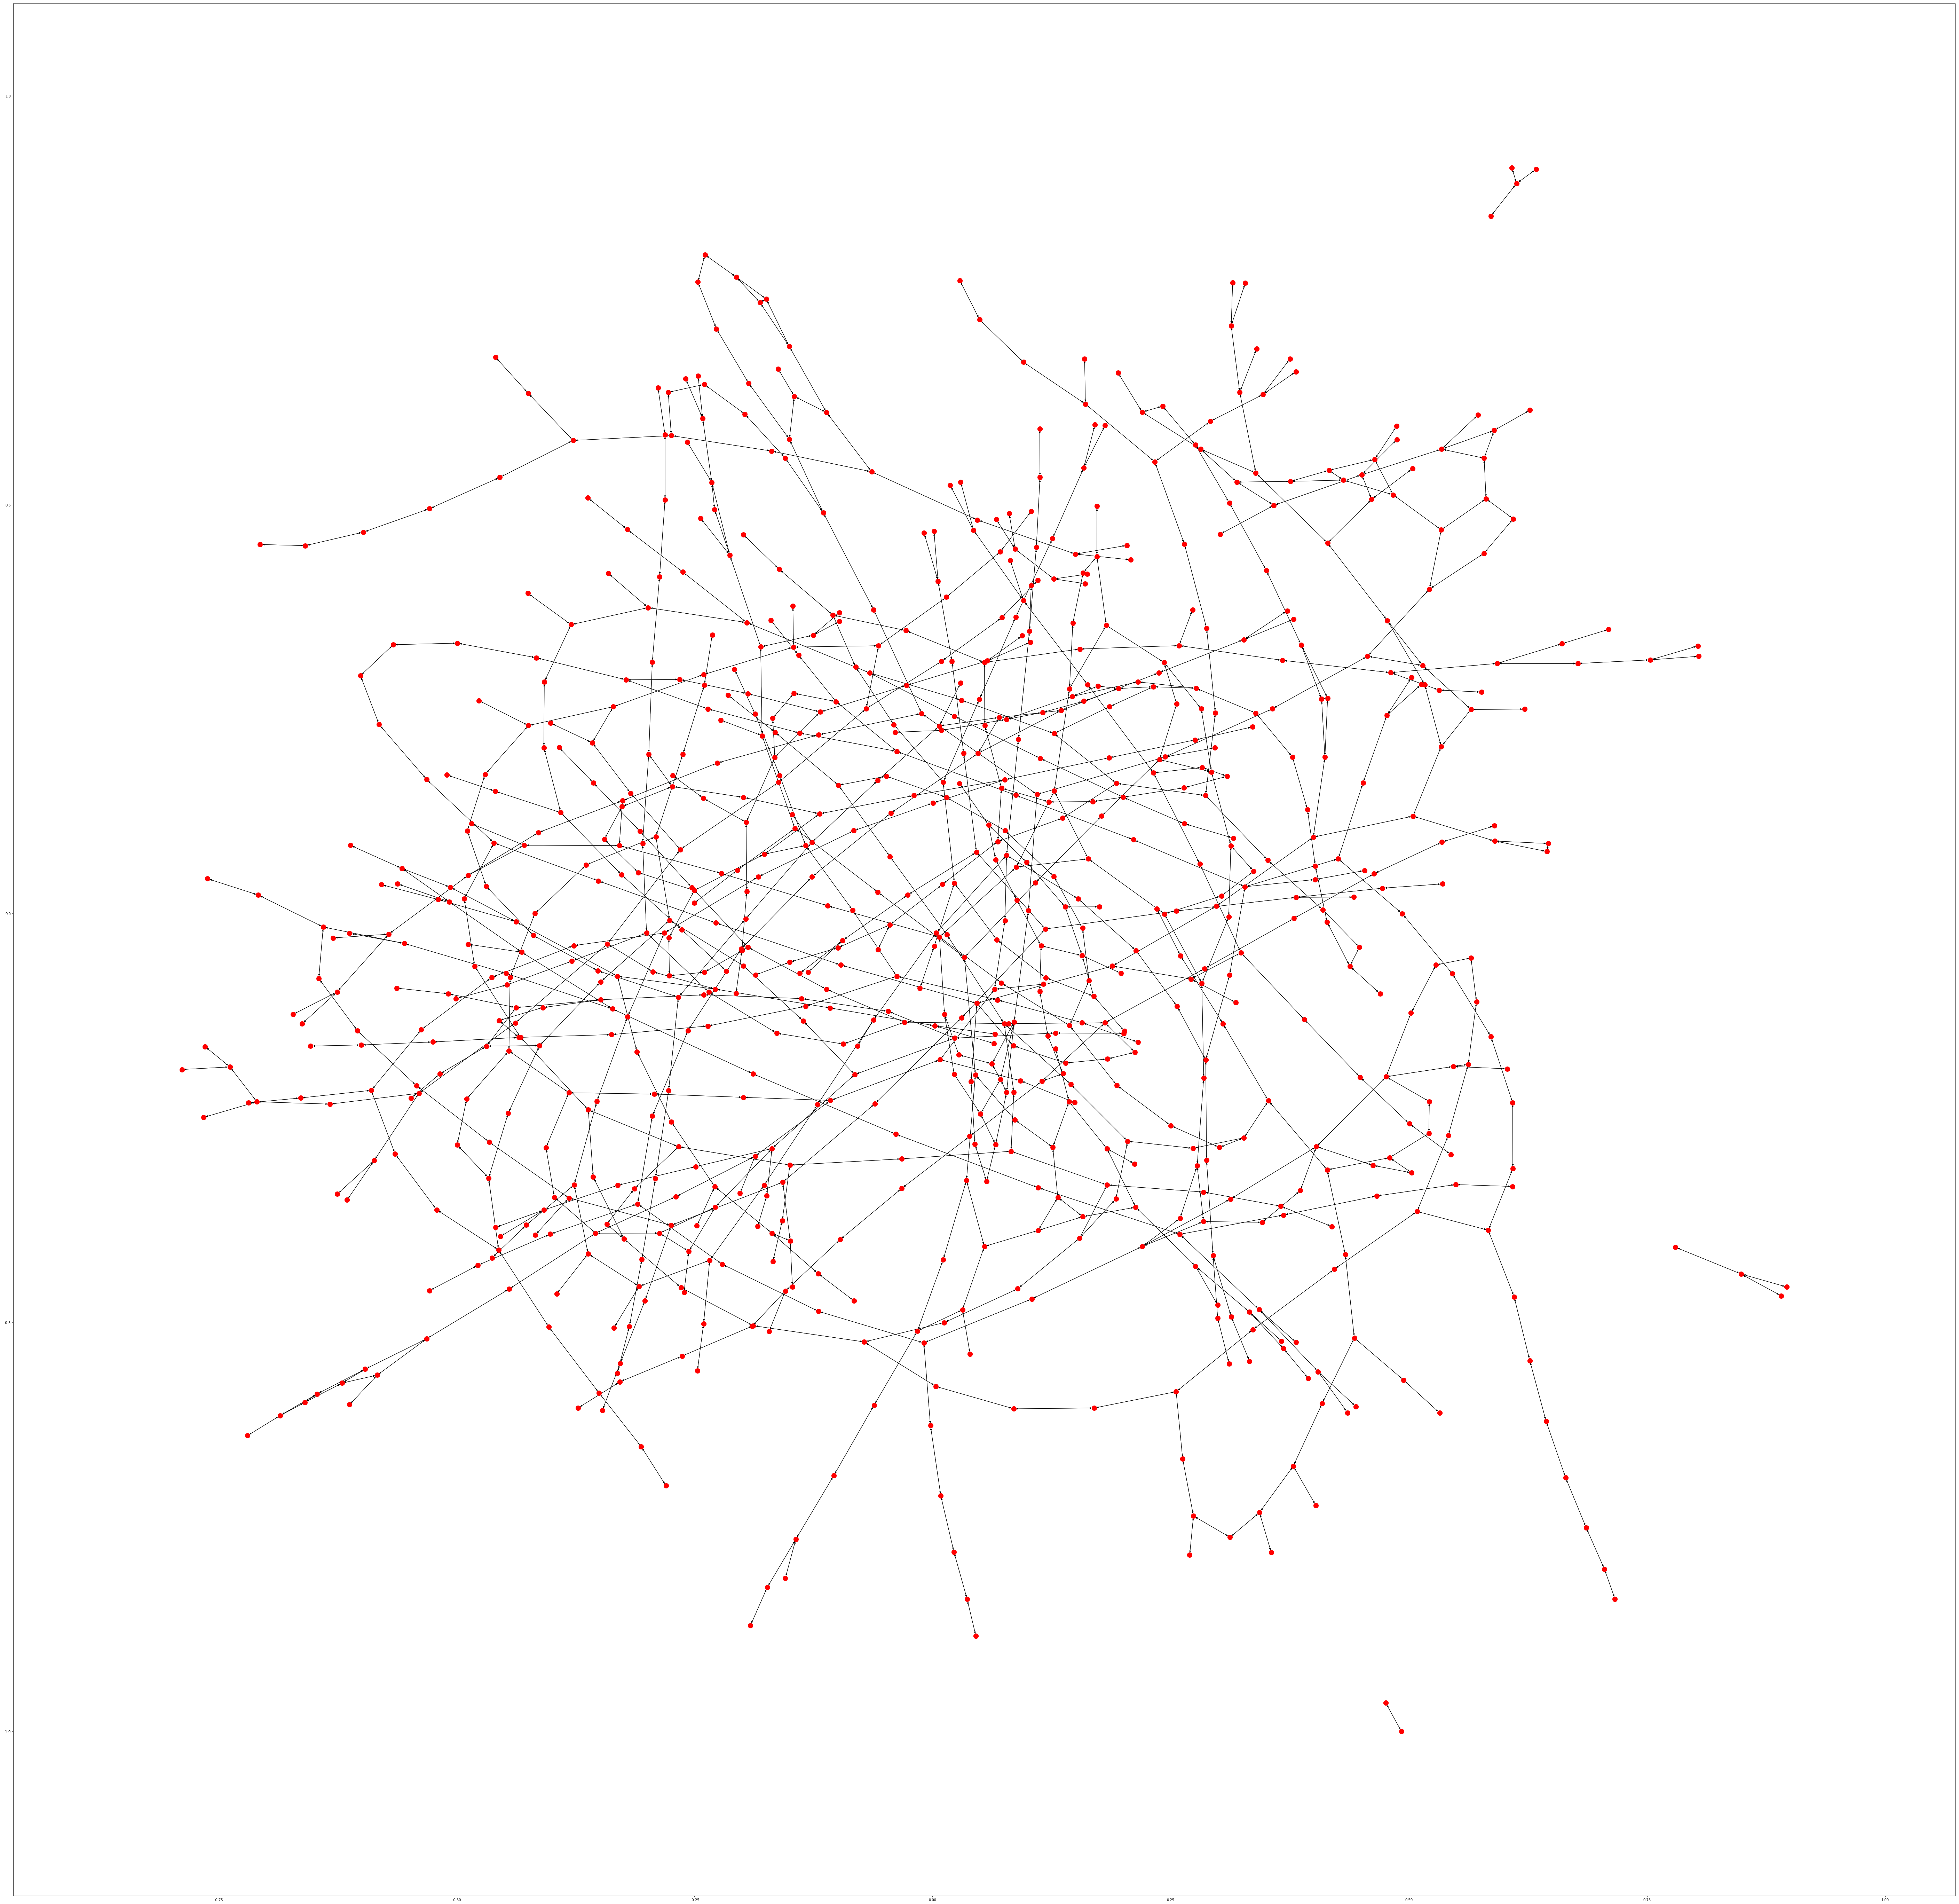

In [22]:
fig, ax = plt.subplots(figsize=(100,100))
nx.draw_networkx(G, with_labels=False, node_size=200)
fig.savefig('network.png')

#### Test if unconnected nodes are really unconnected on the map

In [23]:
#convert to undirected graph
UG = G.to_undirected()
sub_graphs = nx.connected_component_subgraphs(UG)
subs = [sg for i, sg in enumerate(sub_graphs) if len(sg) < 10]

In [24]:
#There are 4 unconnected sub-graphs as confirmed by the image above
len(subs)

4

In [25]:
isolated_nodes = list(subs[0].nodes)

In [26]:
isolated_gpd = gpd.GeoDataFrame(geometry=[Point(shapely.wkb.loads(x)) for x in isolated_nodes], crs={'init':'epsg:27700'})
isolated_gpd['wkt'] = isolated_gpd.geometry.apply(lambda geom:geom.wkt)
isolated_gpd = isolated_gpd.to_crs({'init':'epsg:4326'})

In [27]:
def draw_nodes(df):

    m = folium.Map(location=[55.595754, -2.741771], zoom_start=13, tiles='CartoDB dark_matter',
                   width=800, height=600, prefer_canvas=True)

    tooltip = 'Borders General Hospital'
    folium.Marker([55.595754, -2.741771], popup='<i>Borders General Hospital</i>', tooltip=tooltip).add_to(m)

    #Add road network layer
    style_roads = lambda x: {'color': 'white', 'opacity':1, 'weight':1}
    folium.GeoJson(roads, name='Road network', style_function=style_roads).add_to(m)

    #Add intersections - just for illustration; some markers will exist where same road changes name
    def add_points(row):
        """
        Reversed because Folium needs lat/long and Geopandas keeps things x(long)/y(lat)
        Use tooltips to test if the intersection is correct.
        """
        try:
            for point in row.geometry.coords:
                return folium.CircleMarker(tuple(reversed(point)), radius=1, color='yellow').add_to(m)
        except:
        #multi-points (multiple crossing on the same road)
           for point in row.geometry:
                folium.CircleMarker(tuple(reversed(point.coords[0])), radius=1, color='yellow').add_to(m)

    df.apply(add_points, axis=1)

    #Add radius layer
    style_radius = lambda x: {'fillColor': 'blue', 'fillOpacity':.1}
    folium.GeoJson(radius, name='1500m Radius', style_function=style_radius).add_to(m)

    folium.LayerControl().add_to(m)
    return m

In [28]:
draw_nodes(isolated_gpd)

#### Test a few postcodes to make sure they have a valid path through the graph

In [29]:
pc = 'TD6 9SD'

In [31]:
node_list = (node_df[node_df.desc == pc]
                 .to_crs({'init':'epsg:27700'})
                 .geometry.apply(lambda geom:geom.wkb)
                 .values)

In [32]:
if len(node_list) == 0:
    print("Postcode has no nodes")
else:
    for node in node_list:
        if node in G:
            print(f"{node} found in Network")
        else:
            print(f"{node} not found")

b'\x01\x01\x00\x00\x00\x91u\x9cv\x18\x9e\x15A\x0e\xe5W\xa5\xabY#A' not found
b'\x01\x01\x00\x00\x00\xea\x97\x9cuG\x9f\x15A\xd9r\x8ev\xe1Y#A' found in Network


In [33]:
#target node coordinates (WKB)
node_df[node_df.desc == 'target'].to_crs({'init':'epsg:27700'}).geometry.values[0].wkb

b'\x01\x01\x00\x00\x00\xd2#F\xcf \x91\x15A\x1c\xd5{P\xdeW#A'

In [34]:
l = nx.shortest_path(G,source=b'\x01\x01\x00\x00\x00\xea\x97\x9cuG\x9f\x15A\xd9r\x8ev\xe1Y#A',
                        target=b'\x01\x01\x00\x00\x00\xd2#F\xcf \x91\x15A\x1c\xd5{P\xdeW#A',
                        weight='length')

In [35]:
pc_path_gpd = gpd.GeoDataFrame(geometry=[Point(shapely.wkb.loads(x)) for x in l], crs={'init':'epsg:27700'})
pc_path_gpd['wkt'] = pc_path_gpd.geometry.apply(lambda geom:geom.wkt)
pc_path_gpd = pc_path_gpd.to_crs({'init':'epsg:4326'})

In [36]:
draw_nodes(pc_path_gpd)

#### Find the length of the shortest path

In [37]:
nx.shortest_path_length(G,source=b'\x01\x01\x00\x00\x00\xea\x97\x9cuG\x9f\x15A\xd9r\x8ev\xe1Y#A',
                        target=b'\x01\x01\x00\x00\x00\xd2#F\xcf \x91\x15A\x1c\xd5{P\xdeW#A',
                        weight='length')

1511.4937963133968

#### Function to loop through postcode nodes and calculate the distance for each

In [38]:
def pc_distance_to_source(df, G):
    
    df = df.copy()
    df['wkb'] = df.to_crs({'init':'epsg:27700'}).geometry.apply(lambda geom:geom.wkb)
    
    def path_length(row, attr):
        
        try:
            length = nx.shortest_path_length(G,source=row.wkb,
                        target=b'\x01\x01\x00\x00\x00\xd2#F\xcf \x91\x15A\x1c\xd5{P\xdeW#A',
                        weight=attr)
        except: 
            #null values are ignores when you calculate average for the postcode.
            #Not sure how to specifically capture the custom NodeNotFound exception
            length = np.nan
        
        return length
    
    #driving time based on maximum speeds for each road segment. Not realistic.
    df['length'] = df.apply(path_length, args=('length',), axis=1)
    df['driving_time'] = df.apply(path_length, args=('time',), axis=1)
    
    return df[['desc', 'length', 'driving_time']]

#### Join the length information to the original postcodes file

In [39]:
pc_distance_df = pc_distance_to_source(pc_nodes_df, G).groupby('desc').mean().reset_index()

In [40]:
pc_distance_df[pc_distance_df.length < 1500].head()

desc       length  driving_time
2  TD1 3RS  1258.350554      1.176079
3  TD1 3TE  1260.943644      1.067858
4  TD6 9AA  1345.004122      1.306292
5  TD6 9AB  1100.414255      1.052897
6  TD6 9AD  1146.085884      1.213091

In [41]:
final_postcodes = pd.merge(postcodes, pc_distance_df[pc_distance_df.length < 1500],
                           how='inner', left_on='Postcode', right_on='desc')

#### Plot the resulting network and layers on a Folium map

In [42]:
m = folium.Map(location=[55.595754, -2.741771], zoom_start=13, tiles='CartoDB dark_matter',
               width=800, height=600, prefer_canvas=True)

tooltip = 'Borders General Hospital'
folium.Marker([55.595754, -2.741771], popup='<i>Borders General Hospital</i>', tooltip=tooltip).add_to(m)

#Add all clipped postcodes layer
style_pc = lambda x: {'fillColor': 'white', 'fillOpacity':0.01, 'color':'orange', 'weight':1}
folium.GeoJson(postcodes, name='Postcodes within 1500m - as crow flies',
               style_function=style_pc,
               tooltip=folium.GeoJsonTooltip(fields=['Postcode'])).add_to(m)

#Add postcodes within 1500 metres
style_pc = lambda x: {'fillColor': 'white', 'fillOpacity':0.3, 'color':'orange', 'weight':1}
folium.GeoJson(final_postcodes, name='Postcodes within 1500m - by road network',
               style_function=style_pc,
               tooltip=folium.GeoJsonTooltip(fields=['length'])).add_to(m)

#Add road network layer
style_roads = lambda x: {'color': 'white', 'opacity':1, 'weight':1}
folium.GeoJson(roads, name='Road network', style_function=style_roads,
              tooltip=folium.GeoJsonTooltip(fields=['osm_id'])).add_to(m)

#Add radius layer
style_radius = lambda x: {'fillColor': 'blue', 'fillOpacity':.1}
folium.GeoJson(radius, name='1500m Radius', style_function=style_radius).add_to(m)

folium.LayerControl().add_to(m)
m